In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [3]:
import umap

## 2D regression dataset

In [4]:
num_points = 50
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

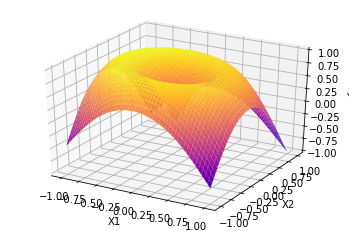

In [5]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [6]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
        self.inv_params = None
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        self.centers.data += torch.randn_like(self.centers)*0.01
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass
    
    def compute_inverse_matrix(self):
#         A = 2*(self.centers.data[1:]-self.centers.data[:-1])
        A = 2*(self.centers[1:]-self.centers[:-1])
        
#         c2 = self.centers.data**2
        c2 = self.centers**2
        Z = (c2[:-1]-c2[1:]).sum(dim=1, keepdim=True)
        
        invA = torch.pinverse(A)
#         invA = A.t()
        self.inv_params = (invA, Z)
        
    def inverse(self, dists):
        assert self.inv_params is not None
        
        d2 = dists**2
        D = d2[:, :-1]-d2[:, 1:]

        invA, Z = self.inv_params
        xrec = torch.matmul(invA, D.t()-Z).t()
        return xrec

In [7]:
class EMA(object):

    def __init__(self, momentum=0.1, mu=None):
        self.mu = mu
        self.momentum = momentum

    def __call__(self, x):
        if self.mu is None:
            self.mu = x
        self.mu = self.momentum*self.mu + (1.0 - self.momentum)*x
        return self.mu

## Distance Embedding of the data

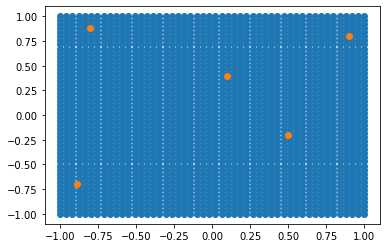

In [8]:
centers = torch.Tensor([[0.9, 0.8],
                        [-0.8, 0.88],
                        [-0.89, -0.7],
                        [0.1, 0.4],
                        [0.5, -0.2]])
plt.scatter(x1, x2)
plt.scatter(*centers.t())

### Find the mapping of centers along with activation

In [9]:
import dtnnlib as dtnn

In [10]:
# dt = dtnn.DistanceTransform_MinExp(2, num_centers=5)
dt = dtnn.DistanceTransform_Exp(2, num_centers=5)

dt.centers.data = centers
dt(xx).shape

torch.Size([2500, 5])

### Now embedding using UMAP

In [11]:
embedder = umap.UMAP(n_neighbors=3, n_components=2, min_dist=0.1, spread=1, metric="euclidean")

In [12]:
embedding = embedder.fit_transform(dt.centers.data.cpu().numpy())
embedding

array([[16.973219  ,  0.24729888],
       [16.671005  ,  1.812561  ],
       [15.734643  ,  1.1278044 ],
       [17.215687  ,  1.11256   ],
       [16.07611   ,  0.26769856]], dtype=float32)

In [13]:
emb = embedding - embedding.mean(axis=0, keepdims=True)
emb

array([[ 0.439085  , -0.6662857 ],
       [ 0.13687134,  0.89897645],
       [-0.7994909 ,  0.21421981],
       [ 0.6815529 ,  0.19897544],
       [-0.45802307, -0.64588606]], dtype=float32)

(-0.9794999837875364,
 0.9894999742507933,
 -0.7799488097429275,
 0.9789252668619156)

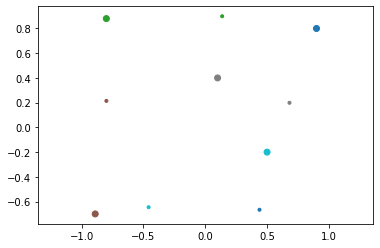

In [14]:
%matplotlib inline
plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.axis('equal')

In [15]:
activs = dt(xx).data.numpy()

In [16]:
i = 40

(-0.8735431194305419,
 0.7556050777435301,
 -0.7445488005876539,
 0.9772395521402357)

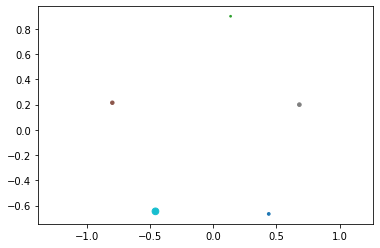

In [17]:
activ = activs[i]
i += 1

# plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), s=np.maximum(activ*80, 0.01), marker='+',cmap='tab10')
plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), s=np.maximum(activ*80, 0.01), cmap="tab10")
plt.axis('equal')

In [22]:
### Use the embedding to select Top-K neurons 

In [112]:
class SpatialAttention(nn.Module):
    
    def __init__(self, num_inputs, num_outputs, out_neighbours, inp_neighbours, embedding_dim):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.out_neighbours = out_neighbours
        self.inp_neighbours = inp_neighbours
        
        embd_dim = embedding_dim
        self.output_embedding = nn.Parameter(torch.randn(num_outputs, embd_dim)/2)
        self.W = None
        self.input_embedding = None
        
        lin = nn.Linear(num_inputs, num_outputs)
        self.weights = nn.Parameter(lin.weight.data.t())
#         self.bias = nn.Parameter(lin.bias.data)

        self.bn = nn.BatchNorm1d(num_outputs)
        
        self.hardness = 0.25
        
    def forward(self, x, input_embedding):
        self.input_embedding = input_embedding
        
        self.weights.data = torch.clamp(self.weights.data, -5, 5)
        ## take winning neuron for selecting neighbours
        winner = x.argmax(dim=1)

        #### take distance between embeddings
        edist = torch.cdist(input_embedding, self.output_embedding)
        
        #### first scale distance to generalized gaussian to select K-nearest neighbours
        A = self.hardness

        topk_edist, _ = torch.topk(edist, k=self.out_neighbours, dim=1, largest=False, sorted=True)
        edge_dist = topk_edist[:, -1:] ## this is equivalent to (1/b)
        b = 1/edge_dist + 1e-5
        scaler = torch.exp(-(edist**2 * b**2)**A)
        
        topk_edist1, _ = torch.topk(edist, k=self.inp_neighbours, dim=0, largest=False, sorted=True)
        edge_dist1 = topk_edist1[-1:]
        b1 = 1/edge_dist1 + 1e-5
        scaler1 = torch.exp(-(edist**2 * b1**2)**A)
        
        
        self.W = scaler
        self.W1 = scaler1
        
        KM = scaler[winner]
        
        ## use this to scale the weights
        ytemp = torch.matmul(x, self.weights*scaler1)
#         y = ytemp*KM + self.bias
        y = self.bn(ytemp*KM)

        return y

In [113]:
sa = SpatialAttention(5, 6, out_neighbours=5, inp_neighbours=3, embedding_dim=2)

In [114]:
sa(dt(xx), torch.Tensor(emb))

tensor([[-1.7625,  0.1911,  2.0888,  2.0581,  0.8866, -1.8104],
        [-1.7678,  0.2407,  2.1213,  2.0615,  0.9130, -1.8088],
        [-1.7729,  0.2890,  2.1529,  2.0645,  0.9387, -1.8076],
        ...,
        [-0.7045,  1.2441, -0.7321, -2.4878, -1.0815, -3.2416],
        [-0.7273,  1.2699, -0.7097, -2.5967, -1.0832, -3.3423],
        [-0.7492,  1.2957, -0.6871, -2.7038, -1.0854, -3.4415]],
       grad_fn=<NativeBatchNormBackward>)

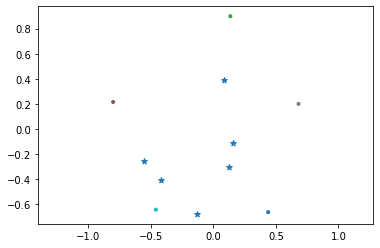

In [115]:
%matplotlib inline
# plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
plt.scatter(*emb.T, c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.scatter(*sa.output_embedding.data.t(), marker='*')
plt.axis('equal')
plt.show()

### Forward propagate using the Spatial Attention

In [116]:
class SpatialMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.dt = dtnn.DistanceTransform_Exp(2, num_centers=5)
        self.dt.centers.data = centers
        self.input_embedding = torch.Tensor(emb)
        
        self.sa1 = SpatialAttention(5, 10, out_neighbours=5, inp_neighbours=3, embedding_dim=2)
        self.sa2 = SpatialAttention(10, 10, out_neighbours=5, inp_neighbours=3, embedding_dim=2)        

#         self.sa1 = SpatialAttention(5, 10, out_neighbours=10, inp_neighbours=5, embedding_dim=2)
#         self.sa2 = SpatialAttention(10, 10, out_neighbours=10, inp_neighbours=10, embedding_dim=2)        

        self.linear = nn.Linear(10, 1)
#         self.actf = nn.LeakyReLU(0.1)
        self.actf = nn.ELU()

        
    def forward(self, x):
        x = self.dt(x)
        x = self.sa1(x, self.input_embedding)
        x = self.actf(x)
        x = self.sa2(x, self.sa1.output_embedding)
        x = self.actf(x)
        x = self.linear(x)
        return x

In [117]:
sanet = SpatialMLP()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sanet.parameters(), lr=0.01)

Step: 0, error: 0.389649
Step: 100, error: 0.004423
Step: 200, error: 0.000969
Step: 300, error: 0.000549
Step: 400, error: 0.000505
Step: 500, error: 0.000263
Step: 600, error: 0.000224
Step: 700, error: 0.000251
Step: 800, error: 0.000247
Step: 900, error: 0.000124
Step: 1000, error: 0.000129
Step: 1100, error: 0.000103
Step: 1200, error: 0.000090
Step: 1300, error: 0.000117
Step: 1400, error: 0.000081
Step: 1500, error: 0.000171
Step: 1600, error: 0.000182
Step: 1700, error: 0.000064
Step: 1800, error: 0.000062
Step: 1900, error: 0.000051
Step: 2000, error: 0.000052
Step: 2100, error: 0.002930
Step: 2200, error: 0.001339
Step: 2300, error: 0.000690
Step: 2400, error: 0.000500
Step: 2500, error: 0.000347
Step: 2600, error: 0.000265
Step: 2700, error: 0.000210
Step: 2800, error: 0.000542
Step: 2900, error: 0.000244
Step: 3000, error: 0.000137
Step: 3100, error: 0.000135
Step: 3200, error: 0.000113
Step: 3300, error: 0.000230
Step: 3400, error: 0.000104
Step: 3500, error: 0.000106
Step

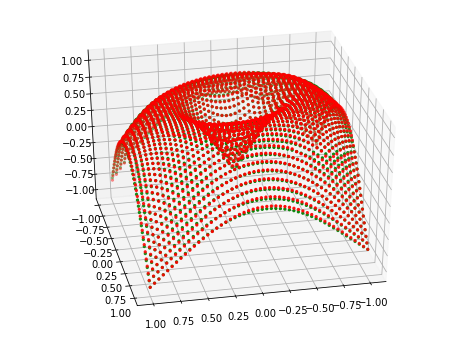

In [118]:
%matplotlib tk

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')

EPOCHS = 12000
for i in range(EPOCHS):
    yout = sanet(xx)
    error = criterion(yout, yy)
    
    optimizer.zero_grad()
    error.backward(retain_graph=True)
    
    optimizer.step()
    
    if i%100 == 0:
        print(f"Step: {i}, error: {error:.6f}")
        
        ax.clear()
        ax.scatter(x1, x2, y, c='g', marker='.')
        ax.scatter(x1, x2, yout.data.numpy().reshape(-1), c='r', marker='.')
        
        fig.canvas.draw()
        plt.pause(0.01)
    if i>0 and i%2000 == 0:
        sanet.sa1.hardness *= 2
        sanet.sa2.hardness *= 2

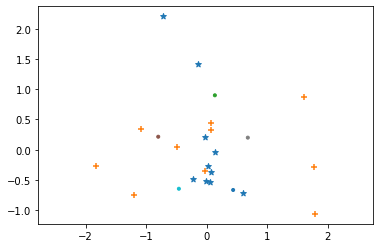

In [119]:
%matplotlib inline
# plt.scatter(*dt.centers.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10')
plt.scatter(*sanet.input_embedding.data.t(), c=np.arange(0, len(dt.centers)), cmap='tab10', marker='.')
plt.scatter(*sanet.sa1.output_embedding.data.t(), marker='*')
plt.scatter(*sanet.sa2.output_embedding.data.t(), marker='+')

plt.axis('equal')
plt.show()

In [120]:
sanet.sa1.W

tensor([[3.9989e-07, 0.0000e+00, 9.6426e-01, 2.5145e-09, 0.0000e+00, 0.0000e+00,
         3.6784e-01, 9.6249e-01, 9.9670e-01, 1.0000e+00],
        [9.6979e-04, 3.1422e-14, 3.6780e-01, 9.9259e-01, 1.0000e+00, 9.9991e-01,
         7.5535e-01, 1.0139e-03, 8.9995e-04, 2.6333e-39],
        [9.1253e-01, 0.0000e+00, 3.6782e-01, 7.4771e-01, 2.7697e-32, 9.9247e-01,
         8.1982e-01, 2.1788e-01, 3.2528e-02, 0.0000e+00],
        [3.1076e-14, 0.0000e+00, 8.1563e-01, 9.9911e-01, 0.0000e+00, 9.8314e-01,
         8.7137e-01, 1.5796e-02, 1.2026e-01, 3.6783e-01],
        [9.9999e-01, 0.0000e+00, 4.5371e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.6784e-01, 9.8849e-01, 9.1003e-01, 0.0000e+00]],
       grad_fn=<ExpBackward>)

In [121]:
sanet.sa1.weights

Parameter containing:
tensor([[ 0.8513,  0.0650, -0.6873,  0.8715, -0.4176,  0.4804, -0.5678,  0.5431,
          0.7568,  0.8214],
        [-0.4557,  0.0720, -0.5140, -0.6430,  0.5589, -0.1292, -0.6333, -0.4197,
         -1.4233,  0.3846],
        [ 0.0190,  0.3440, -0.4186,  0.2404, -1.1374,  0.3560,  0.7369,  0.2152,
         -0.3343,  0.4301],
        [ 0.2074, -0.3527,  0.7872,  0.4400, -0.1693, -1.0149,  0.5680, -0.9858,
          0.1654, -0.0350],
        [-0.1949, -0.5864,  0.7682, -0.6953, -0.0709, -0.0802,  0.7884, -0.3425,
         -0.3377, -0.9347]], requires_grad=True)

In [122]:
line_collection = []
weight_collection = []

sa = sanet.sa2

saW = sa.W #W1
for i, inp in enumerate(sa.input_embedding):
    p0 = tuple(inp.tolist())
    for j, out in enumerate(sa.output_embedding):
        p1 = tuple(out.tolist())
        
        line_collection.append([p0,p1])
        weight_collection.append(float(saW[i,j]))
#         break
        
line_collection, weight_collection = np.array(line_collection), np.array(weight_collection)

In [123]:
line_collection

array([[[-0.22470936, -0.48173794],
        [ 1.78372133, -0.28390014]],

       [[-0.22470936, -0.48173794],
        [-1.20333934, -0.75360703]],

       [[-0.22470936, -0.48173794],
        [-1.82466173, -0.26915774]],

       [[-0.22470936, -0.48173794],
        [-0.48264396,  0.0475079 ]],

       [[-0.22470936, -0.48173794],
        [ 1.60836279,  0.87415165]],

       [[-0.22470936, -0.48173794],
        [ 0.07126519,  0.43774638]],

       [[-0.22470936, -0.48173794],
        [ 1.80030036, -1.06208217]],

       [[-0.22470936, -0.48173794],
        [-0.02761655, -0.35370997]],

       [[-0.22470936, -0.48173794],
        [-1.08683872,  0.33748984]],

       [[-0.22470936, -0.48173794],
        [ 0.0759415 ,  0.31914946]],

       [[-0.72864491,  2.20591116],
        [ 1.78372133, -0.28390014]],

       [[-0.72864491,  2.20591116],
        [-1.20333934, -0.75360703]],

       [[-0.72864491,  2.20591116],
        [-1.82466173, -0.26915774]],

       [[-0.72864491,  2.20591116],
  

In [124]:
weight_collection

array([0.00000000e+00, 3.67819458e-01, 0.00000000e+00, 9.99837518e-01,
       0.00000000e+00, 6.39197409e-01, 0.00000000e+00, 1.00000000e+00,
       3.77250240e-06, 9.37922418e-01, 8.26766094e-44, 8.99371400e-04,
       2.53340065e-01, 9.60154176e-01, 2.89018363e-01, 9.93331790e-01,
       0.00000000e+00, 3.67722958e-01, 9.95145857e-01, 9.83907640e-01,
       2.07591051e-23, 3.67800504e-01, 0.00000000e+00, 9.99972641e-01,
       0.00000000e+00, 9.99717236e-01, 0.00000000e+00, 1.00000000e+00,
       2.77584493e-01, 9.99978185e-01, 1.82740027e-29, 8.67267218e-08,
       0.00000000e+00, 9.99989152e-01, 0.00000000e+00, 9.99999881e-01,
       0.00000000e+00, 1.00000000e+00, 3.67804021e-01, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 9.74424481e-01,
       1.92296982e-01, 9.99896646e-01, 0.00000000e+00, 3.67774904e-01,
       9.65775609e-01, 9.99389589e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.99996841e-01, 0.00000000e+00, 1.00000000e+00,
      

In [125]:
weight_collection.min(), weight_collection.max()

(0.0, 1.0)

In [126]:
from matplotlib import collections
import matplotlib as mpl

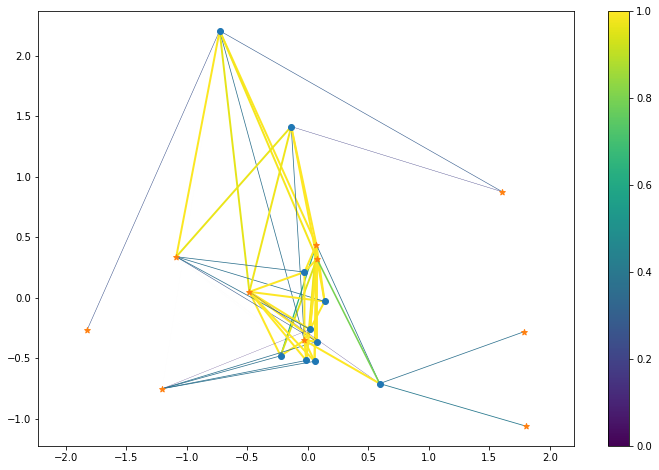

In [127]:
## plot attention weights
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

# lc = collections.LineCollection(line_collection, linewidths=weight_collection*5, zorder=-2)
lc = collections.LineCollection(line_collection, 
                                array=weight_collection, 
                                linewidths= weight_collection*2, 
#                                 norm=mpl.colors.Normalize(vmin=-0, vmax=2),
#                                 cmap="PiYG", 
                                zorder=-2, )

# lc.set_array(weight_collection)
ax.add_collection(lc)
axcb = fig.colorbar(lc)

# ax.autoscale()
# ax.margins(0.1)

plt.scatter(*sa.input_embedding.data.t(), cmap='tab10', marker='o')
plt.scatter(*sa.output_embedding.data.t(), marker='*')

plt.axis('equal')
plt.show()

In [128]:
sa.hardness

8.0